# TRABAJO Parte 2: AIA_2024-2025

# Nombre y DNI del alumno/a 1: GUILLERMO BLANCO DÍAZ 31020304C
# Nombre y DNI del alumno/a 2:

# Transfer Learning con CNNs - Dataset: Flowers

La idea de este trabajo es familiarizarnos con dos situaciones muy habituales en la actividad real de un "Machine Learning Engineer":

1.   En primer lugar, con una de las técnicas más potentes asociadas con las redes neuronales: el **Transfer Learning**. Dado que las redes neuronales, para resolver un problema, capturan en su estructura de capas y pesos una representación jerárquica del problema.
Entonces..., ¿por que no aprovechar ese conocimiento obtenido, para resolver otro problema diferente?

2.  En segundo lugar, con la **busqueda de información sobre conceptos nuevos**. En este caso, los dos primeros modelos a implementar los hemos trabajado en clase. No así el Transfer Learning, y por tanto, debereis buscar vosotros mismos como hacer lo que se pide para el Modelo 3. Consultar en blogs, web y tutoriales es algo común en el día a día de alguien que quiere profundizar en el ML y, para ello, existen infinidad de fuentes. A modo de ejemplo, una fuente para profundizar en el Transfer Learning con redes convolucionales es: https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/

En este trabajo vamos intentar resolver un problema de clasificación sobre un dataset propuesto por Tensorflow en 2019 conocido como "flowers". Este conjunto está formado por 3670 imágenes de flores pertenecientes a 5 clases diferentes. Para ello implementaremos 3 modelos:

*   Modelo 1: implementación de una CNN básica.
*   Modelo 2: es una evolución del modelo anterior, aplicando técnicas que reduzcan el overfitting.
*   Modelo 3: rompemos la barrera de tener que seguir complicando nuestro modelo y se pide aplicar transfer learning utilizando un pre-trained model.





# a) Carga de datos

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd

import pathlib
import os
import glob
import shutil
tf.__version__

'2.18.0'

In [2]:
import warnings
warnings.filterwarnings('ignore')

Descargamos el dataset que pone a nuestra disposición Tensorflow.

In [3]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True,
                                   )

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Tras completar la descarga, debemos tener la siguiente estructura de directorios:  

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>~/.keras/datasets/flower_photos_extracted/flower_photos</b>
|__ <b>daisy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
</pre>

Desgraciadamente, para este dataset, Tensorflow no nos proporciona la estructura de directorios necesaria de train y de validación. Por lo que debemos proceder del siguiente modo:

* Crear una carpeta `train` y de `val`, cada una de ellas debe contener a su vez, cinco subdirectorios: uno para cada clase de flor.
* Moveremos las imágenes de las carpetas originales a estas nuevas carpetas. De modo que el 80% de las imágenes vayan al conjunto de train y el 20% restante al de validación.
* La estructura final de directorios debe ser la siguiente:

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>~/.keras/datasets/flower_photos_extracted/flower_photos</b>
|__ <b>train</b>
    |______ <b>daisy</b>: [12.jpg, 28.jpg, 31.jpg ....]
    |______ <b>dandelion</b>: [41.jpg, 22.jpg, 35.jpg ....]
    |______ <b>roses</b>: [121.jpg, 92.jpg, 38.jpg ....]
    |______ <b>sunflowers</b>: [93.jpg, 23.jpg, 83.jpg ....]
    |______ <b>tulips</b>: [109.jpg, 267.jpg, 93.jpg ....]
 |__ <b>val</b>
    |______ <b>daisy</b>: [507.jpg, 508.jpg, 509.jpg ....]
    |______ <b>dandelion</b>: [719.jpg, 720.jpg, 721.jpg ....]
    |______ <b>roses</b>: [514.jpg, 515.jpg, 516.jpg ....]
    |______ <b>sunflowers</b>: [560.jpg, 561.jpg, 562.jpg .....]
    |______ <b>tulips</b>: [640.jpg, 641.jpg, 642.jpg ....]
</pre>

Creamos una lista con el nombre de las 5 clases. En castellano sería: margaritas, diente de león, rosas, girasoles y tulipanes.

In [4]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

Creemos la estructura de directorios necesaria:

In [5]:
base_dir = os.path.expanduser("~/.keras/datasets/flower_photos_extracted/flower_photos/")

Preparamos variables con las rutas de los diferentes directorios a crear:

In [6]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

daisy_dir = os.path.join(train_dir, 'daisy')
dandelion_dir = os.path.join(train_dir, 'dandelion')
roses_dir = os.path.join(train_dir, 'roses')
sunflowers_dir = os.path.join(train_dir, 'sunflowers')
tulips_dir = os.path.join(train_dir, 'tulips')

In [7]:
SPLIT_RATIO=0.8

for cl in classes:
    # path de las imagenes de la clase cl
    img_path = os.path.join(base_dir, cl)

    # obtenemos la lista de todas las imagenes
    images = glob.glob(img_path + '/*.jpg')
    print("{}: {} Imagenes".format(cl, len(images)))

    # determinamos cuantas imagenes son el 80%
    num_train = int(round(len(images)*SPLIT_RATIO))

    # separamos las imagenes en dos listas
    train, val = images[:num_train], images[num_train:]

    # creamos la carpeta de train/clase y val/clase
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
        os.makedirs(os.path.join(base_dir, 'train', cl))
    else:
        shutil.rmtree(os.path.join(base_dir, 'train', cl))

    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
        os.makedirs(os.path.join(base_dir, 'val', cl))
    else:
        shutil.rmtree(os.path.join(base_dir, 'val', cl))

    for t in train:
        shutil.move(t, os.path.join(base_dir, 'train', cl))

    for v in val:
        shutil.move(v, os.path.join(base_dir, 'val', cl))


roses: 641 Imagenes
daisy: 633 Imagenes
dandelion: 898 Imagenes
sunflowers: 699 Imagenes
tulips: 799 Imagenes


Hemos incluído una semilla para que salga el mismo resultado al ejecutar

In [8]:
SEED = 43
keras.utils.set_random_seed(SEED)

**Tarea 1: Muestre el nombre de dos ficheros cualquiera en alguna de esas rutas**

In [9]:
# Ruta donde está el dataset extraído
base_dir = os.path.expanduser("~/.keras/datasets/flower_photos_extracted/flower_photos/train")

# Ejemplo para la clase "daisy"
daisy_dir = os.path.join(base_dir, "daisy")
train_daisy_files = os.listdir(daisy_dir)

print("Dos archivos de la clase 'daisy':")
print(train_daisy_files[:2])


Dos archivos de la clase 'daisy':
['14621687774_ec52811acd_n.jpg', '14163875973_467224aaf5_m.jpg']


Es decir, la clase a la que pertenece cada imagen no viene dada por el nombre del fichero sino por el directorio en el que se encuentra almacenada.

**Tarea 2: Muestra el número de imágenes de train que tenemos de cada clase**

In [10]:
daisy_dir = os.path.join(base_dir, "daisy")
dandelion_dir = os.path.join(base_dir, "dandelion")
roses_dir = os.path.join(base_dir, "roses")
sunflowers_dir = os.path.join(base_dir, "sunflowers")
tulips_dir = os.path.join(base_dir, "tulips")

train_daisy_files = os.listdir(daisy_dir)
train_dandelion_files = os.listdir(dandelion_dir)
train_roses_files = os.listdir(roses_dir)
train_sunflowers_files = os.listdir(sunflowers_dir)
train_tulips_files = os.listdir(tulips_dir)

print('trainining daisy:', len(train_daisy_files))
print('trainining dandelion:', len(train_dandelion_files))
print('trainining roses:', len(train_roses_files))
print('trainining sunflowers:', len(train_sunflowers_files))
print('trainining tulips:', len(train_tulips_files))


trainining daisy: 506
trainining dandelion: 718
trainining roses: 513
trainining sunflowers: 559
trainining tulips: 639


# b) Visualización del dataset

**Tarea 3: Muestra 3 imágenes de cada una de las clases, el título de la imagen será el shape del array de numpy asociado a la imagen**

In [11]:
next_daisy_pix = [os.path.join(daisy_dir, fname) for fname in train_daisy_files[0:3]]
next_dandelion_pix = [os.path.join(dandelion_dir, fname) for fname in train_dandelion_files[0:3]]
next_roses_pix = [os.path.join(roses_dir, fname) for fname in train_roses_files[0:3]]
next_sunflowers_pix = [os.path.join(sunflowers_dir, fname) for fname in train_sunflowers_files[0:3]]
next_tulips_pix = [os.path.join(tulips_dir, fname) for fname in train_tulips_files[0:3]]

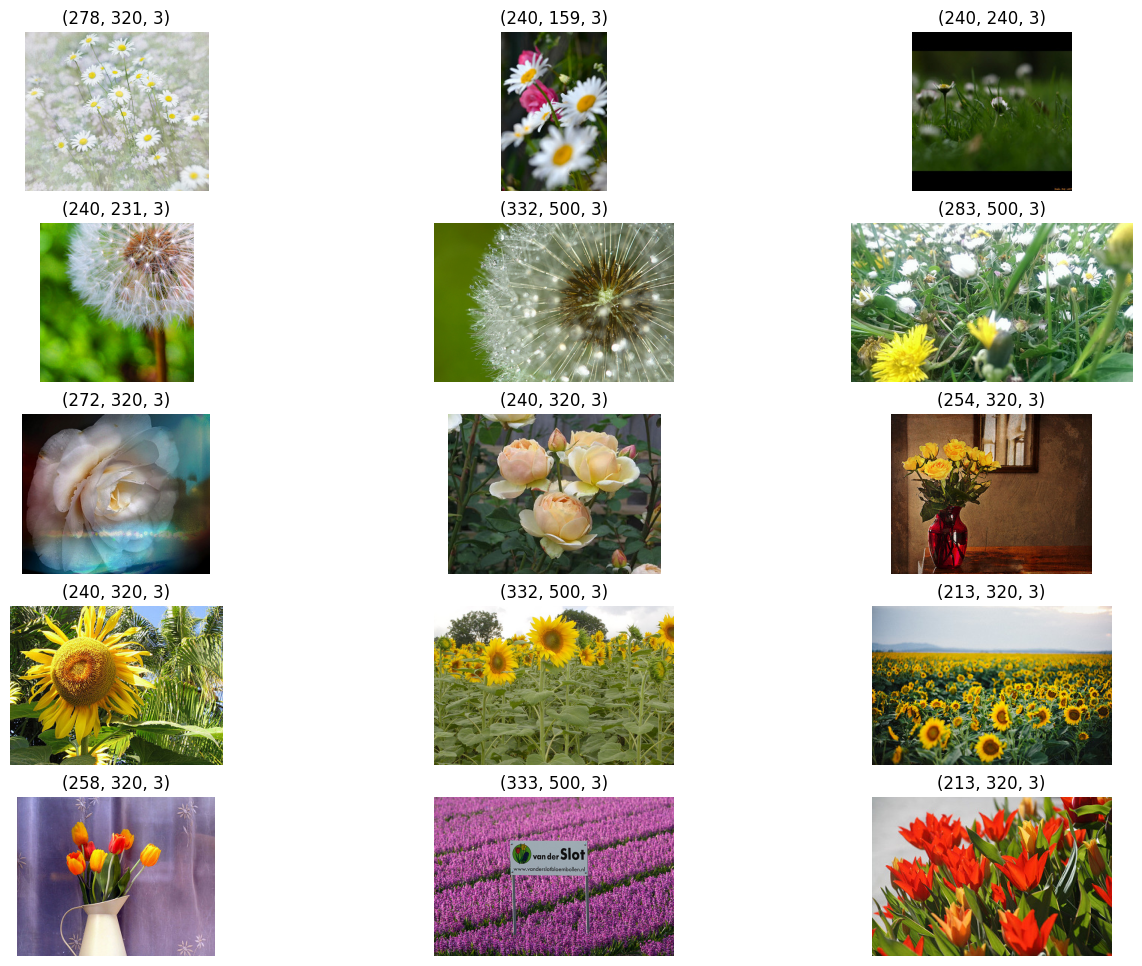

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(16,12))
for i, img_path in enumerate(next_daisy_pix + next_dandelion_pix + next_roses_pix + next_sunflowers_pix + next_tulips_pix):
  sp = plt.subplot(5, 3, i + 1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  plt.title(img.shape)
  plt.imshow(img)


# c) Modelo 1: CNN básica (objetivo: accuracy_valid > 60%)


Implemente una red convolucional para resolver el problema de clasificación. Para ello se sugiere una CNN con 3 capas convolucionales + pooling con la siguiente estructura:

Bloque de procesamiento de imagen:
1.   32 kernels -> 64 kernels -> 96 kernels
2.   kernels de 3x3.
3.   Stride = 1 y padding = SI.
4.   Función de activación ReLU.
5.   Maxpooling de 2x2 con stride clásico de 2 pixeles.
6.   Igualamos el tamaño de todas las imágenes a 150 x 150.

Bloque de decisión:
7.   Capa densa de 512 neuronas.
8.   Capa densa de salida.

**Tarea 4: Define un modelo con la estructura anterior**



In [13]:
model = keras.Sequential()

# Añadimos capa Conv2D con 32 kernels de tamaño de kernel (3x3) con padding, stride = 1 y funcion activacion relu
model.add(keras.layers.Conv2D(
              filters=32,                       #Numero de kernels
              kernel_size=(3, 3),               #Tamaño del kernel
              strides=(1, 1),                   #Tamaño del stride
              padding='same',                   # Con Padding
              activation='relu',                # Funcion de activacion -> relu
              name='conv1',
              input_shape=(150, 150, 3)))       #Tamaño de la entrada
# Añadimos capa MaxPooling2D de tamaño 2 con stride = 2
model.add(keras.layers.MaxPooling2D(
              pool_size=(2, 2),
              strides=(2, 2)))

# Añadimos capa Conv2D con 64 kernels de tamaño de kernel(3x3) con padding, stride = 1 y funcion activacion relu
model.add(keras.layers.Conv2D(64, 3, activation='relu',padding='same', name='conv2'))

# Añadimos capa MaxPooling2D de tamaño 2 con stride = 2
model.add(keras.layers.MaxPooling2D(2))

# Añadimos capa Conv2D con 96 kernels de tamaño de kernel(3x3) con padding, stride = 1 y funcion activacion relu
model.add(keras.layers.Conv2D(96, 3, activation='relu',padding='same', name='conv3'))

# Añadimos capa MaxPooling2D de tamaño 2 con stride = 2
model.add(keras.layers.MaxPooling2D(2))

# Añadimos capa Flatten
model.add(tf.keras.layers.Flatten())

# Añadimos capa Dense de tamaño 512 y con funcion de activacion relu
model.add(keras.layers.Dense(units=512, activation='relu'))
# Añadimos capa Dense de tamaño 5 y con funcion de activacion softmax
model.add(keras.layers.Dense(units=5, activation='softmax'))

**Tarea 5: Indica el shape de la imagen antes y después de cada capa de la red. Explica cómo has obtenido dichos valores**

|Capa| Shape a la entrada| Operacion de la capa| Shape a la salida|#parámetros
|:-|:-:|:-:|:-:|:-:|
|Conv_1|(None, 150, 150, 3)|32 kernels 3x3, padding='same'|(None, 150, 150, 32)|(3×3×3+1)×32=896
|Pool_1|(None, 150, 150, 32)|MaxPool 2x2, stride 2|(None, 75, 75, 32)|0
|Conv_2|(None, 75, 75, 32)|64 kernels 3x3, padding='same'|(None, 75, 75, 64)|(3×3×32+1)×64=18496
|Pool_2|(None, 75, 75, 64)|MaxPool 2x2, stride 2|(None, 37, 37, 64)|0
|Conv_3|(None, 37, 37, 64)|96 kernels 3x3, padding='same'|(None, 37, 37, 96)|(3×3×64+1)×96=55392
|Pool_3|(None, 37, 37, 96)|MaxPool 2x2, stride 2|(None, 18, 18, 96)|0
|flatten|(None, 18, 18, 96)|Aplanar 18 * 18 * 96|(None, 31104)|0
|densa_1|(None, 31104)|512 neuronas|(None, 512)|(31104+1)×512=15925760
|Output|(None, 512)|5 neuronas (para 5 clases)|(None, 5)|(512+1)×5=2565





**Tarea 6: Compara el resultado con un summary() del modelo**


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 37, 37, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 31104)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    15,925,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,003,109 (61.05 MB)

 Trainable params: 16,003,109 (61.05 MB)

 Non-trainable params: 0 (0.00 B)

**Tarea 7: Entrena el modelo de manera que obtenga un accuracy (sobre el conjunto de validación) > 60%.**

* Utilice el optimizador que considere más adecuado.
*   Recuerda que si no se realiza conversión a One-Hot de la etiqueta a predecir, debes utilizar como función de error `SparseCategoricalCrossentropy` (este es el procedimiento que hemos usado en clase).
*   Considera un learning rate en el entorno de 0.001.
*   En el caso de los generators utiliza `class_mode='sparse'`.
*   Puedes utilizar p.e. un `batch_size = 100`.

Configuramos el motor de aprendizaje, el objetivo a minimizar y el criterio de evaluacion del modelo

In [15]:
# Compilamos el modelo creado
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Generamos los datos de entrenamiento y validacion

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

Configuramos los generadores de entrenamiento  validacion para cargar imagenes directamente desde un directorio

In [17]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=100,
        class_mode='sparse')

validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=100,
        class_mode='sparse')

Found 2935 images belonging to 5 classes.
Found 735 images belonging to 5 classes.


In [18]:
# Calculamos el numero de pasos que se realizaran en cada epoca de entrenamiento y validacion
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

# entrenamos el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=2
)

Epoch 1/15
29/29 - 20s - 682ms/step - accuracy: 0.4095 - loss: 1.4264 - val_accuracy: 0.4543 - val_loss: 1.2454
Epoch 2/15
29/29 - 3s - 114ms/step - accuracy: 0.3500 - loss: 1.2152 - val_accuracy: 0.4900 - val_loss: 1.1805
Epoch 3/15
29/29 - 10s - 354ms/step - accuracy: 0.5937 - loss: 1.0030 - val_accuracy: 0.5571 - val_loss: 1.0868
Epoch 4/15
29/29 - 1s - 49ms/step - accuracy: 0.6700 - loss: 1.0881 - val_accuracy: 0.5629 - val_loss: 1.0564
Epoch 5/15
29/29 - 7s - 250ms/step - accuracy: 0.6741 - loss: 0.8499 - val_accuracy: 0.6286 - val_loss: 1.0460
Epoch 6/15
29/29 - 2s - 81ms/step - accuracy: 0.6300 - loss: 0.8630 - val_accuracy: 0.6371 - val_loss: 0.9756
Epoch 7/15
29/29 - 7s - 250ms/step - accuracy: 0.7252 - loss: 0.7130 - val_accuracy: 0.6514 - val_loss: 0.9615
Epoch 8/15
29/29 - 3s - 102ms/step - accuracy: 0.7800 - loss: 0.6011 - val_accuracy: 0.6486 - val_loss: 0.9633
Epoch 9/15
29/29 - 7s - 250ms/step - accuracy: 0.7975 - loss: 0.5473 - val_accuracy: 0.6486 - val_loss: 1.0079
E

**Tarea 8: Muestra la evolución de la función de error (train y valid) durante el entrenamiento.Explica que problema presenta el modelo que hemos entrenado.**

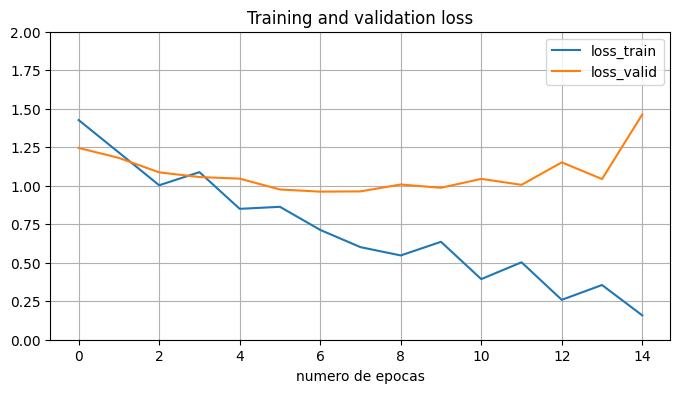

In [19]:
pd.DataFrame({'loss_train': history.history['loss'],
              'loss_valid': history.history['val_loss']}).plot(figsize=(8,4))

plt.grid(True)
plt.ylim(0,2)
plt.xlabel('numero de epocas')
plt.title('Training and validation loss');

Ésta gráfica muestra un claro indicio de overfitting. Podemos observar como la función de error en entrenamiento baja constantemente hasta valores muy bajos mientras que la función de error de validación comienza bajando en las primeras épocas pero, a partir de las épocas 9-10, empieza a estancarse y luego incluso a subir.

Por tanto el problema que presenta este modelo es que si dejamos que siga entrenando todas las épocas al final acabará adaptándose y memorizando las imágenes del entrenamiento y por ello su rendimiento empeorará. Para combatir este problema podemos aplicar varias técnicas: Early stoping, data augmentation, dropout, etc.

# d) Modelo 2: reducción del overfitting (objetivo: accuracy_valid > 70%)

Para mejorar el accuracy del modelo, vamos a incorporar las dos técnicas más habituales de reducción del overfitting:

    * drop-out
    * data augmentation
    

**Tarea 9: Explica en que consisten y qué utilidad tienen para nuestro problema**





**Dropout**


*   **¿En qué consiste?**
El Dropout es una técnica de regularización que consiste en "desactivar" aleatoriamente un porcentaje de neuronas (y sus conexiones) en una capa durante cada paso del entrenamiento. Esto significa que estas neuronas no contribuyen a la activación hacia adelante ni a la propagación hacia atrás durante esa iteración específica. Durante la inferencia (cuando el modelo hace predicciones), todas las neuronas están activas, pero sus pesos se escalan por el factor de dropout para compensar.
*   **Utilidad para nuestro problema**
    *    **Reduce el Co-adaptación**: Evita que las neuronas dependan demasiado unas de otras, forzándolas a aprender características más robustas y generalizables de forma independiente. Si una neurona está "apagada", otras tienen que aprender a compensar.
    *    **Crea "múltiples modelos"**: En cada iteración, el modelo entrena una red ligeramente diferente. Es como si estuvieras entrenando un ensemble de modelos en lugar de uno solo, lo que mejora la robustez y reduce el sobreajuste.
    *    **Previene el Overfitting**: Al hacer el modelo menos sensible a los pesos específicos de cualquier neurona individual, reduce la tendencia del modelo a memorizar los datos de entrenamiento y mejora su capacidad de generalización a datos no vistos.

**Data Augmentation**
*   **¿En qué consiste?** El Data Augmentation es una técnica para expandir artificialmente el tamaño de nuestro conjunto de datos de entrenamiento generando nuevas imágenes "modificadas" a partir de las existentes. Estas modificaciones pueden incluir rotaciones, volteos, zooms, cambios de brillo, recortes, etc. Es importante que estas transformaciones sean realistas y no alteren la clase de la imagen. Por ejemplo, una flor girada sigue siendo la misma flor.
*   **Utilidad para nuestro problema**
    *   **Aumenta la cantidad de datos de entrenamiento**: Las redes neuronales, especialmente las CNNs profundas, requieren una gran cantidad de datos para entrenar eficazmente. Nuestro dataset de flores, puede no ser suficiente para que el modelo aprenda todas las variaciones posibles. El aumento de datos simula un dataset más grande y diverso.
    *   **Mejora la Generalización**: Al exponer el modelo a diversas variaciones de las imágenes existentes, el modelo aprende a ser más robusto a pequeñas variaciones en las imágenes de entrada.
    *   **Previene el Overfitting**: Al introducir más diversidad en el conjunto de entrenamiento, el modelo tiene menos posibilidades de memorizar patrones específicos del conjunto original y se ve obligado a aprender características más invariantes y útiles para la clasificación, lo que reduce el sobreajuste.




**Tarea 10: Construye un nuevo modelo 2 incorporando (en el modelo 1 anterior) el dropout adecuado**

In [20]:
model_2 = keras.Sequential()

# Añadimos capa Conv2D con 32 kernels de tamaño de kernel (3x3) con padding, stride = 1 y funcion activacion relu
model_2.add(keras.layers.Conv2D(32,3,padding='same',activation='relu',input_shape=(150, 150, 3)))

# Añadimos capa MaxPooling2D de tamaño 2 con stride = 2
model_2.add(keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))

# Añadimos capa Conv2D con 64 kernels de tamaño de kernel (3x3) con padding, stride = 1 y funcion activacion relu
model_2.add(keras.layers.Conv2D(64, 3, activation='relu',padding='same', name='conv2'))

# Añadimos capa MaxPooling2D de tamaño 2 con stride = 2
model_2.add(keras.layers.MaxPooling2D(2))

# Añadimos capa Conv2D con 96 kernels de tamaño de kernel (3x3) con padding, stride = 1 y funcion activacion relu
model_2.add(keras.layers.Conv2D(96, 3, activation='relu',padding='same', name='conv3'))

# Añadimos capa MaxPooling2D de tamaño 2 con stride = 2
model_2.add(keras.layers.MaxPooling2D(2))

# Añadimos capa Flatten
model_2.add(tf.keras.layers.Flatten())

# Añadimos capa Dense de tamaño 512 con funcion de activacion relu
model_2.add(keras.layers.Dense(units=512, activation='relu'))

# Añadimos el Dropout del 50%
model_2.add(keras.layers.Dropout(rate=0.5, name='dropout'))

# Añadimos capa Dense de tamaño 5 con funcion de activacion softmax
model_2.add(keras.layers.Dense(units=5, activation='softmax'))

**Tarea 11: Explica que tipos de augmentation vas a considerar y que utilidad tienen en nuestro problema de clasificacion**

**Rescale (rescale=1./255)**: Normaliza los píxeles al rango [0, 1], lo cual ayuda a estabilizar y acelerar el entrenamiento. Esta parte se aplica tanto a train como a validation, ya que en ambos queremos que la red reciba valores en el mismo rango.

**Rotations (rotation_range=40)**: En flores, la orientación de la cámara puede variar: a veces fotografiamos la flor desde arriba, otras desde un ángulo lateral. Esto introduce robustez frente a pequeñas rotaciones, de manera que la red aprenda a reconocer la flor con distintas inclinaciones.

**Traslaciones horizontales y verticales (width_shift_range=0.2, height_shift_range=0.2)**: Con esta transformación obligamos al modelo a no depender de que la flor siempre esté justo en el centro, sino que aprenda a identificarla incluso si aparece desplazada.

**Shear (shear_range=0.2)**: Desliza filas o columnas en ángulo.

**Zoom (zoom_range=0.2)**: Con el zoom evitamos que el modelo dependa de un tamaño fijo de flor dentro del cuadro.

**Horizontal flip (horizontal_flip=True)**: Voltea la imagen de izquierda a derecha. En algunos casos también podría valer un vertical_flip, pero con flores reales el flip vertical puede ser antinatural. Por eso, en este caso usamos solo horizontal_flip.

In [21]:
# Preparamos las tecnicas que vamos a realizar sobre las imagenes
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )

val_datagen = ImageDataGenerator(rescale=1.0/255)

In [22]:
# Cargamos los datos de entrenamiento y validacion
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=100,
    class_mode='sparse'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=100,
    class_mode='sparse'
)

Found 2935 images belonging to 5 classes.
Found 735 images belonging to 5 classes.


**Tarea 12: Entrena el modelo de manera que obtenga un accuracy (sobre el conjunto de validación) > 70%.**

In [23]:
model_2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['acc'])

Aplicamos también Early Stopping

In [24]:
# Configuramos el Early Stopping
es_callback = keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)

In [25]:
# Calculamos el numero de pasos que se realizaran en cada epoca de entrenamiento y validacion
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

# Entrenamos el modelo
history_2 = model_2.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[es_callback],                           #Ahora aplicamos el early stopping
    verbose=2
)

Epoch 1/30
29/29 - 26s - 887ms/step - acc: 0.3316 - loss: 1.5140 - val_acc: 0.4329 - val_loss: 1.2971
Epoch 2/30
29/29 - 1s - 48ms/step - acc: 0.4200 - loss: 1.2589 - val_acc: 0.4429 - val_loss: 1.3144
Epoch 3/30
29/29 - 21s - 717ms/step - acc: 0.4899 - loss: 1.1893 - val_acc: 0.5100 - val_loss: 1.2012
Epoch 4/30
29/29 - 1s - 52ms/step - acc: 0.4500 - loss: 1.2361 - val_acc: 0.5029 - val_loss: 1.1903
Epoch 5/30
29/29 - 21s - 725ms/step - acc: 0.5658 - loss: 1.0724 - val_acc: 0.5400 - val_loss: 1.2356
Epoch 6/30
29/29 - 1s - 49ms/step - acc: 0.6200 - loss: 0.9105 - val_acc: 0.5100 - val_loss: 1.3120
Epoch 7/30
29/29 - 39s - 1s/step - acc: 0.6141 - loss: 1.0101 - val_acc: 0.5800 - val_loss: 1.0926
Epoch 8/30
29/29 - 2s - 53ms/step - acc: 0.5500 - loss: 1.0891 - val_acc: 0.5871 - val_loss: 1.0711
Epoch 9/30
29/29 - 21s - 721ms/step - acc: 0.6205 - loss: 0.9583 - val_acc: 0.5871 - val_loss: 1.0901
Epoch 10/30
29/29 - 1s - 50ms/step - acc: 0.5200 - loss: 1.0966 - val_acc: 0.5957 - val_loss:

**Tarea 13: Muestra la evolucion de la funcion de error durante el entrenamiento. Explica qué diferencias de comportamiento hay entre las gráficas del modelo 1 y el modelo 2**

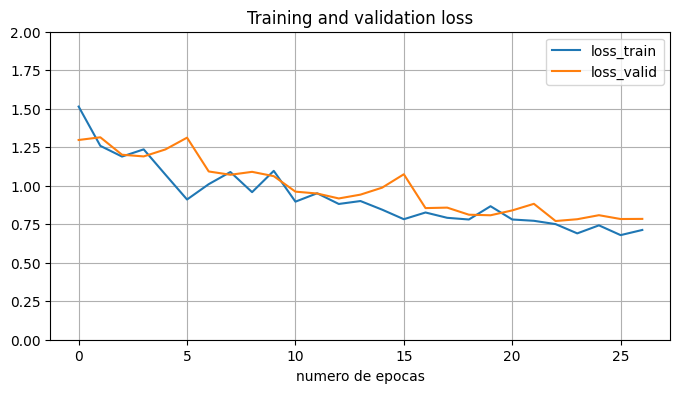

In [26]:
pd.DataFrame({'loss_train': history_2.history['loss'],
              'loss_valid': history_2.history['val_loss']}).plot(figsize=(8,4))

plt.grid(True)
plt.ylim(0,2)
plt.xlabel('numero de epocas')
plt.title('Training and validation loss');

La principal diferencia entre la grafica del modelo 1 y la del modelo 2 es el sobreajuste. La grafica del modelo 1 presentaba un gran sobreajuste que provocaba una gran diferencia entre la perdida de entrenamiento y la perdida de validacion a lo largo de las epocas. Esto se soluciona en el modelo 2 utilizando Dropout y diversas tecnicas de Data Augmentation consiguiendo asi reducir el Overfitting y que las perdidas de entrenamiento y validacion tengan valores mas similares.

# c) Modelo 3: Transfer Learning (objetivo: accuracy_valid > 88%)

En nuestro problema de clasificación de flores, el utilizar CNNs diseñadas y entrenadas por nosotros mismos, aparece una barrera en las proximidades del 75-77% de precisión del modelo (siempre sobre validación).

Para superar este escollo, el siguiente paso natural es la utilización de modelos preentrenados. Existe una gran variedad de ellos basados en redes CNNs clásicas, donde la principal diferencia es que acumulan más capas que nuestros modelos 1 y 2. Adicionalmente, en estos modelos se han ido incorporando diferentes propuestas para mejorar la arquitectura de la CNN.

En general, utilizando estos modelos convolucionales preentrenados podemos alcanzar accuracies próximos al 90%. Normalmente, estos modelos han sido previamente entrenados sobre datasets de gran tamaño y con gran número de categorías. P.e. en subconjuntos de Imagenet (14 millones de imagenes de 22K categorías).

Dado que estos modelos se entrenaron para resolver un problema "relativamente" parecido a nuestro problema de clasificación, parece razonable pensar que podemos aprovechar ese conocimiento capturado en la red para resolver nuestro problema de clasificación de flores.



Para elegir el modelo preentrenado que debe utilizar cada grupo, proceda del siguiente modo:
* Paso 1: sume los DNIs de los componentes del grupo (si el grupo tiene un sólo miembro, vaya directamente al paso 2). res = dni_1 + dn_2
* Paso 2: Aplique la siguiente operación al resultado anterior: res mod 6.
* Paso 3: Tome el modelo cuyo número asociado coincide con el resultado de la operación anterior.
* Paso 4: El porcentaje que aparece entre paréntesis junto al nombre del modelo es el accuracy (en validación) que deberías poder alcanzar sin dificultad utilizando el modelo. En todos los casos considera un input_shape = (224, 224, 3).

  0. Resnet50 (>90%)
  https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50

  1. Resnet101 (>90%) input_shape = (224, 224, 3)
  https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/ResNet101

  2. VGG16 (>90%) input_shape = (224, 224, 3)
  https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16

  3. VGG19 (>90%) input_shape = (224, 224, 3) https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg19/VGG19

  4. Xception (>88%) input_shape = (224, 224, 3) https://www.tensorflow.org/api_docs/python/tf/keras/applications/xception/Xception

  5. Inceptionv3 (>88%) input_shape = (224, 224, 3) https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/InceptionV3

P.e. si los DNIs de los alumnos son: 12345678 y 23456781. La suma es 35802459. De donde 35802459 mod 6 = 3. Por tanto, tomaríamos el modelo VGG16.

Recuerda que puedes utilizar el siguiente post como referencia del uso de transfer learning: https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/

**Tarea 14: Importa el modelo desde Tensorflow**

Dado que este modelo ha sido entrenado para clasificar entre 1.000 categorías, las capas densas finales del modelo no son útiles para nuestro problema de clasificación de 5 categorías (es lo que suele llamarse include_top = SI/NO). De manera que eliminamos lo que a veces se suele llamar el "top model". De este modo sólo nos quedamos con la parte que hace la funcionalidad de "procesamiento" de la imagen.

Utilizaremos **Xception** ya que sum_dni mod 6 = 4

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model

# Definicion del tamaño de la entrada
INPUT_SHAPE = (224, 224, 3)

# Cargar el modelo utilizando Xception
base_model = Xception(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

base_model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_2[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

**Tarea 15: Personalizar el bloque de decisión**  
Añadimos una capa de flatten y tres nuevas capas densas especificas para nuestro problema con dimensiones 4096, 1072 y la que necesite la capa de salida (con sus correspondientes drop-outs).

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Obtener la salida de la base convolucional del modelo pre-entrenado
x = base_model.output

# Añadir la capa Flatten
x = Flatten()(x)

# Añadimos una capa Dense de tamaño 512 con funcion de activacion relu
x = Dense(512, activation='relu')(x)

# Introducimos un Dropout del 50%
x = Dropout(0.5)(x)

# Añadimps la segunda capa Dense de tamaño 128 con funcion de activacion relu y su Dropout
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Añadimos la capa de salida
# La dimensión de esta capa debe ser igual al número de categorías.
NUM_CLASSES = 5

# Utilizamos como capa de salida una capa Dense con el tamaño del numero de clases y con funcion de activacion softmax
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Construimos el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_2[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 72,308,525 (275.84 MB)

 Trainable params: 72,253,997 (275.63 MB)

 Non-trainable params: 54,528 (213.00 KB)

**Tarea 16: Congelar los pesos que no se vayan a entrenar**

Previo a hacer el denominado `Fine-Tuning` del modelo, indicaremos a Tensorflow que únicamente debe entrenar:

   * Las dos últimas capas convolucionales de la red preentrenada, de las que realizaremos un ajuste fino de los pesos.
   * Las tres capas densas que hemos incluido nuevas.

In [ ]:
print("Configurando la entrenabilidad de las capas de la base_model (Xception)...")

# Iteramos sobre cada capa en nuestra 'base_model'.
for layer in base_model.layers:
    # Por defecto, "congelamos" todas las capas de la base_model.
    layer.trainable = False
print("Todas las capas de la base_model han sido inicialmente congeladas.")

# Creamos una lista de capas de la base_model que realmente tienen pesos entrenables.
# Excluimos las capas de pooling
trainable_layers_in_base_model = [layer for layer in base_model.layers if len(layer.weights) > 0]

# Definimos cuántas de las últimas capas entrenables de la base_model queremos "descongelar".
num_layers_to_unfreeze = 2

# Verificamos si tenemos suficientes capas entrenables para descongelar el número deseado.
if len(trainable_layers_in_base_model) >= num_layers_to_unfreeze:
    # Iteramos sobre las últimas 'num_layers_to_unfreeze' capas entrenables de la base_model.
    for layer in trainable_layers_in_base_model[-num_layers_to_unfreeze:]:
        # Establecemos 'trainable = True' para estas capas, permitiendo que sus pesos se actualicen.
        layer.trainable = True
        print(f"   -> Capa descongelada para entrenamiento: {layer.name}")
else:
    print(f"Advertencia: El número de capas a descongelar ({num_layers_to_unfreeze}) es mayor que las capas entrenables disponibles en la base_model ({len(trainable_layers_in_base_model)}).")

print("Configuración de entrenabilidad de la base_model completada.")

model.summary()

print("\nEstado de entrenabilidad detallado de las capas del modelo final:")
for layer in model.layers:
    print(f"{layer.name}: {layer.trainable}")

Configurando la entrenabilidad de las capas de la base_model (Xception)...
Todas las capas de la base_model han sido inicialmente congeladas.
   -> Capa descongelada para entrenamiento: block14_sepconv2
   -> Capa descongelada para entrenamiento: block14_sepconv2_bn
Configuración de entrenabilidad de la base_model completada.


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_2[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 72,308,525 (275.84 MB)

 Trainable params: 54,610,693 (208.32 MB)

 Non-trainable params: 17,697,832 (67.51 MB)


Estado de entrenabilidad detallado de las capas del modelo final:
input_layer_2: False
block1_conv1: False
block1_conv1_bn: False
block1_conv1_act: False
block1_conv2: False
block1_conv2_bn: False
block1_conv2_act: False
block2_sepconv1: False
block2_sepconv1_bn: False
block2_sepconv2_act: False
block2_sepconv2: False
block2_sepconv2_bn: False
conv2d_1: False
block2_pool: False
batch_normalization: False
add: False
block3_sepconv1_act: False
block3_sepconv1: False
block3_sepconv1_bn: False
block3_sepconv2_act: False
block3_sepconv2: False
block3_sepconv2_bn: False
conv2d_2: False
block3_pool: False
batch_normalization_1: False
add_1: False
block4_sepconv1_act: False
block4_sepconv1: False
block4_sepconv1_bn: False
block4_sepconv2_act: False
block4_sepconv2: False
block4_sepconv2_bn: False
conv2d_3: False
block4_pool: False
batch_normalization_2: False
add_2: False
block5_sepconv1_act: False
block5_sepconv1: False
block5_sepconv1_bn: False
block5_sepconv2_act: False
block5_sepconv2: Fa

**Tarea 17: Crear los datagenerators oportunos**

Para ello:
> * Utiliza Data augmentation.  
> * Las imágenes tienen que ser preprocesadas igual que cuando se entrenó el modelo pre.entrenado original. Para ello se utiliza el parámetro `preprocessing_function=preprocess_input` (preprocess_input importado desde `keras.applications.xxxxxx` en ambos generators (train y valid). Por tanto, no hay que indicarle `rescale`. En caso de ser necesario, se encargará `preprocess_input`.  
> * Dado que estamos reutilizando un modelo que no "es nuestro", deberemos ceñirnos al tamaño de imagen que permite la red a la entrada. Recuerda que debe ser: 224x224.

In [ ]:
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
preprocess_input = xception_preprocess_input

print("Configurando Data Generators...")

# Parámetros comunes
IMAGE_SIZE = (224, 224) # Requerido por Xception
BATCH_SIZE = 32         # Un tamaño de batch común
NUM_CLASSES = 5


# Creamos el Data Generator para el conjunto de entrenamiento
# Con Data Augmentation y el preprocesamiento específico de Xception
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Creamos el Data Generator para el conjunto de validación
valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # Solo preprocesamiento
)

# Creamos los generadores de flujo de datos
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,       # Redimensiona todas las imágenes
    batch_size=BATCH_SIZE,
    class_mode='categorical',     # Para clasificación multi-clase
    shuffle=True                  # Mezcla las imágenes para el entrenamiento
)

validation_generator = valid_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,       # Redimensiona todas las imágenes
    batch_size=BATCH_SIZE,
    class_mode='categorical',     # Para clasificación multi-clase
    shuffle=False                 # No es necesario mezclar para la validación
)

print("Compilando el modelo...")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nData Generators creados con éxito.")
print(f"Imágenes de entrenamiento encontradas: {train_generator.samples} pertenecientes a {train_generator.num_classes} clases.")
print(f"Imágenes de validación encontradas: {validation_generator.samples} pertenecientes a {validation_generator.num_classes} clases.")
print(f"Mapeo de clases (class_indices): {train_generator.class_indices}")

Configurando Data Generators...
Found 2935 images belonging to 5 classes.
Found 735 images belonging to 5 classes.
Compilando el modelo...

Data Generators creados con éxito.
Imágenes de entrenamiento encontradas: 2935 pertenecientes a 5 clases.
Imágenes de validación encontradas: 735 pertenecientes a 5 clases.
Mapeo de clases (class_indices): {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


**Tarea 18: Haz el fine-tuning del modelo con el objetivo de alcanzar un accuracy (sobre el conjunto de validación > 88%).**

A la hora de entrenar un modelo pretrained es típico bajar el learning rate respecto al que utilizaríamos para un modelo nuestro desde cero.

Iniciando el Fine-Tuning del modelo Xception...
Epoch 1/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.5407 - loss: 4.7440
Epoch 1: val_accuracy improved from -inf to 0.85653, saving model to ./checkpoints/best_xception_model.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 83s 722ms/step - accuracy: 0.5418 - loss: 4.7247 - val_accuracy: 0.8565 - val_loss: 0.4590
Epoch 2/30
 1/91 ━━━━━━━━━━━━━━━━━━━━ 16s 179ms/step - accuracy: 0.6875 - loss: 1.9558
Epoch 2: val_accuracy did not improve from 0.85653
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6875 - loss: 1.9558 - val_accuracy: 0.8565 - val_loss: 0.4494
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.7484 - loss: 0.9380
Epoch 3: val_accuracy improved from 0.85653 to 0.87642, saving model to ./checkpoints/best_xception_model.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 54s 595ms/step - accuracy: 0.7487 - loss: 0.9370 - val_accuracy: 0.8764 - val_loss: 0.3373
Epoch 4/30
 1/91 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step - accuracy: 0.90

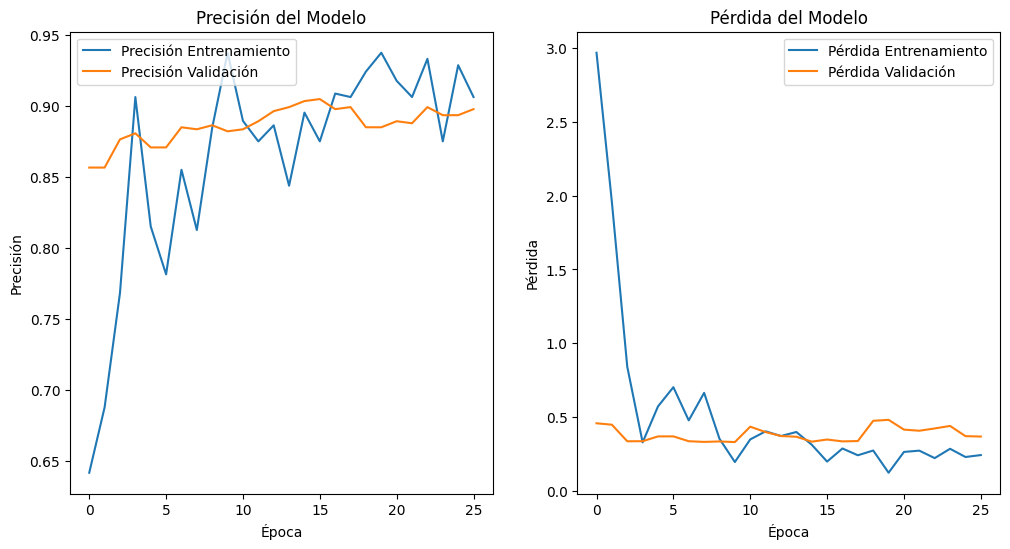

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')


print("Iniciando el Fine-Tuning del modelo Xception...")

# Parámetros de entrenamiento
EPOCHS = 30
INITIAL_EPOCH = 0

# ModelCheckpoint: Guarda el mejor modelo (según la precisión de validación)
checkpoint_filepath = './checkpoints/best_xception_model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,               # Guarda solo el "mejor" modelo
    monitor='val_accuracy',
    mode='max',
    save_weights_only=False,
    verbose=1
)

# EarlyStopping
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=10,                       # Detiene si no hay mejora en 10 épocas
    mode='max',
    restore_best_weights=True,
    verbose=1
)

# Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size, # Número de batches por época
    epochs=EPOCHS,
    initial_epoch=INITIAL_EPOCH,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size, # Número de batches por validación
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)

print("\nFine-Tuning completado.")

# Evaluar el modelo final
# Carga el mejor modelo guardado por ModelCheckpoint
model = tf.keras.models.load_model(checkpoint_filepath)

# Evalúa el modelo en el conjunto de validación
loss, accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size, verbose=0)
print(f"Precisión final en el conjunto de validación: {accuracy:.4f}")

# Graficar el historial de entrenamiento

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión Validación')
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida Validación')
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(loc='upper right')

plt.show()